In [1]:
import os
import sys
import networkx as nx
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from epynet import Network

sys.path.insert(0, os.path.join('..'))
from utils.graph_utils import get_nx_graph, get_sensitivity_matrix
from utils.DataReader import DataReader
from utils.SensorInstaller import SensorInstaller

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]

In [2]:
wds_id = 'ctown'

### Loading WDS topology

In [3]:
path_to_wds = os.path.join('..', 'water_networks', wds_id+'.inp')
wds = Network(path_to_wds)
G = get_nx_graph(wds, mode='weighted')
installer = SensorInstaller(wds, include_pumps_as_master=True)

In [4]:
coords = {}
for node in wds.nodes:
    arr = [node.coordinates[0], node.coordinates[1]]
    coords[int(node.index)] = arr

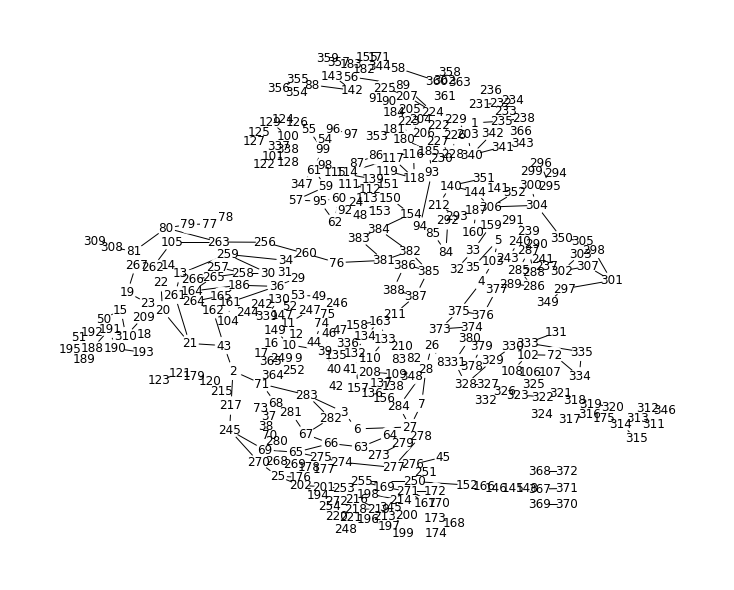

In [5]:
node_colors = ['#ffffff' for _ in G.nodes]
nx.draw(G, pos=coords, with_labels=True, node_color=node_colors)

### Loading signal

In [6]:
path_to_data = os.path.join('..', 'data', 'db_'+wds_id+'_doe_pumpfed_1')
reader = DataReader(path_to_data, n_junc=len(wds.junctions.uid), obsrat=.1, seed=1234)

In [7]:
signal, _, _ = reader.read_data(
    dataset = 'trn',
    varname = 'junc_heads',
    rescale = None,
    cover = False
)

In [8]:
devs = signal.std(axis=0).T[0]
node_order = np.argsort(devs)[::-1]+1

mmscaler = MinMaxScaler()
scaled_devs = mmscaler.fit_transform(devs.reshape(-1, 1))[:,0]

In [9]:
signal.std(axis=0).T.shape

(1, 388)

### Collecting master nodes

In [10]:
master_nodes = installer.master_nodes

### Calculating sensitivity matrix

In [11]:
pert = np.max(wds.junctions.basedemand)/100
S = get_sensitivity_matrix(wds, pert)

### Shortest path selection

In [12]:
sensor_budget = 2
# installer.deploy_by_random(sensor_budget=sensor_budget, seed=88867)
# installer.deploy_by_shortest_path(sensor_budget=sensor_budget, weight_by=None)
# installer.deploy_by_shortest_path(sensor_budget=sensor_budget, weight_by='length')
# installer.deploy_by_shortest_path(sensor_budget=sensor_budget, weight_by='iweight', sensor_nodes=set(installer.master_nodes))
installer.deploy_by_shortest_path_with_sensitivity(
    sensor_budget = sensor_budget,
    sensitivity_matrix = S,
    weight_by = 'iweight',
    aversion = 0
)
# installer.set_sensor_nodes(set(np.loadtxt(os.path.join('..', 'experiments', 'models', 
#                         'ctown-random-0.015-binary-placement-4_sensor_nodes.csv'))))

sensor_nodes = installer.sensor_nodes

### Sensor placement plot

In [13]:
node_arr = np.array(G.nodes)
node_colors = ['#ffffff' for _ in G.nodes]
node_sizes = [1 for _ in G.nodes]
for node in master_nodes:
    try:
        node_colors[np.where(node_arr == node)[0][0]] = '#ff0000'
        node_sizes[np.where(node_arr == node)[0][0]] = 50
    except:
        print(node)
for node in sensor_nodes:
    node_colors[np.where(node_arr == node)[0][0]] = '#008000'
    node_sizes[np.where(node_arr == node)[0][0]] = 50

edge_colors = ['#000000' for _ in G.edges]
paths = installer.get_shortest_paths(installer.sensor_nodes)
edge_colors = []
for edge in G.edges:
    flag = False
    for path in paths:
        if edge in path.edges:
            flag = True
    if flag:
        edge_colors.append('#ff0000')
    else:
        edge_colors.append('#000000')

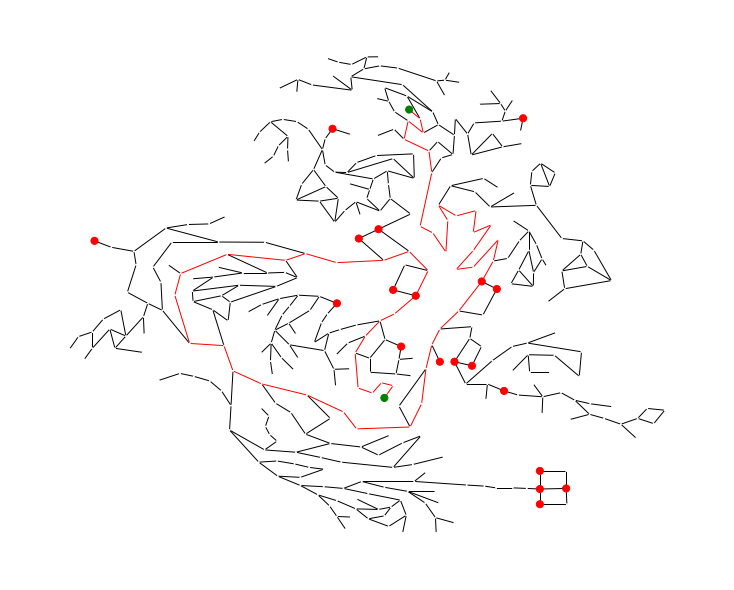

In [14]:
nx.draw(
    G,
    pos=coords,
    with_labels=False, node_color=node_colors, edge_color=edge_colors, alpha=None, node_size=node_sizes)

### Truncated graph

In [15]:
node_arr = np.array(G.nodes)
node_colors = ['#ffffff' for _ in G.nodes]
node_sizes = [1 for _ in G.nodes]

# selected_nodes = set(np.arange(3)+1)
selected_nodes = sensor_nodes

for node in selected_nodes:
    node_colors[np.where(node_arr == node)[0][0]] = '#008000'
    node_sizes[np.where(node_arr == node)[0][0]] = 50

edge_colors = []
for edge in G.edges:
    if edge[0] in selected_nodes or edge[1] in selected_nodes:
        edge_colors.append('#ff0000')
    else:
        edge_colors.append('#80ffff')

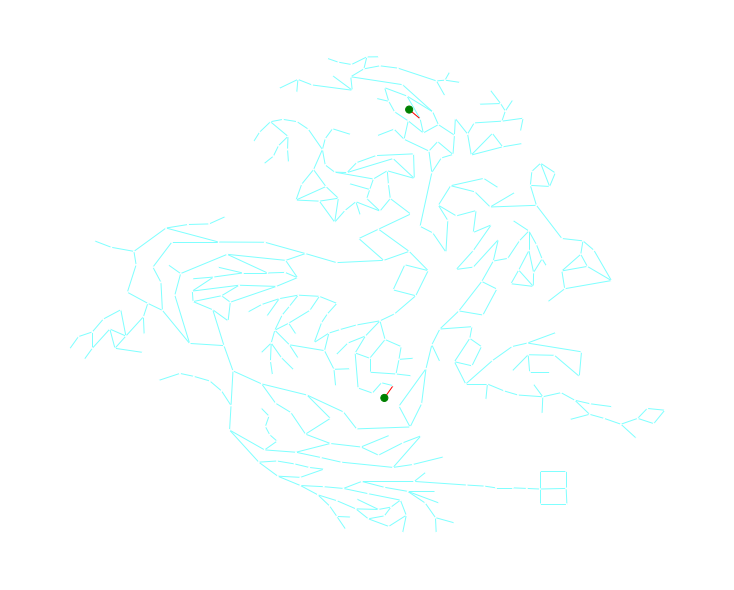

In [16]:
nx.draw(
    G,
    pos=coords,
    with_labels=False, node_color=node_colors, edge_color=edge_colors, alpha=None, node_size=node_sizes)

# Nodes with highest head variation

In [17]:
cmap = plt.get_cmap('viridis')

node_arr = np.array(G.nodes)
node_colors = ['#ffffff' for _ in G.nodes]
node_sizes = [50 for _ in G.nodes]

for node in G.nodes:
    nidx = np.where(node_arr == node)[0][0]
    cidx = np.where(wds.junctions.index.values == node)[0][0]
    node_colors[nidx] = cmap(scaled_devs[cidx])

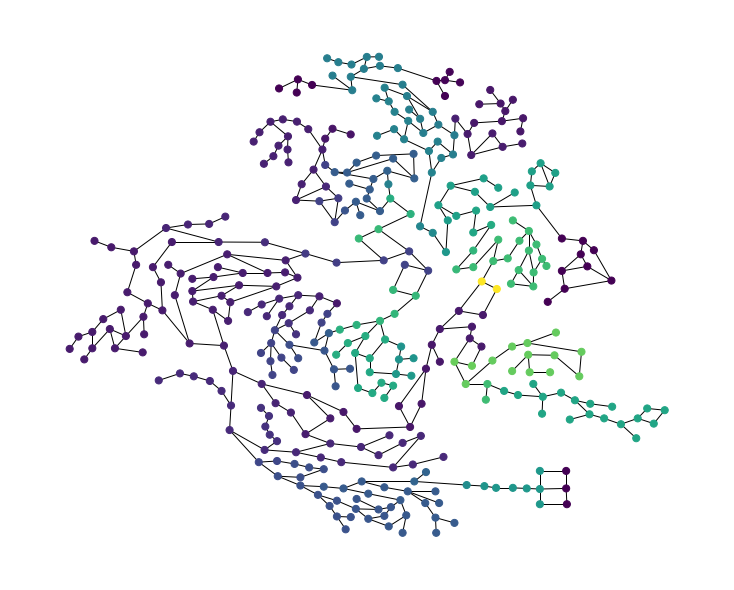

In [18]:
nx.draw(
    G,
    pos=coords,
    with_labels=False, node_color=node_colors, node_size=node_sizes)